<a href="https://colab.research.google.com/github/carloshvmoraes/MASHSG/blob/main/MASHSG_Basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Working Files

In [ ]:
!pip install pandapower

In [ ]:
#@title
import pandapower as pp
import pandapower.plotting as plot
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import base64
import io 

class MASHSG:
    """Distributed Intelligent System for SelfHealing in Smart Grids"""

    def __init__(
        self, 
        net: pp.pandapowerNet = None, 
        jsonNet: str = None, 
        debugView : str = None,
        ):
        '''
        Create a Intelligent Agent for Self Healing Grid

        Parameters:
        :net - pandapowerNet Grid
        :jsonNet - Json Grid File
        :debugView
            :None - disabled,
            :"Full" - Messages and Switchs
            :"Messages" - Only Messages
            :"Switchs" - Only Switchs
        '''

        # carrega em arquivo circuito dos ramais
        if (jsonNet is not None) and (net is None):
            net = pp.from_json(jsonNet)
        # circuito dos ramais
        self.net = net 
        # salva estado anterior das chaves para resetar simulação
        self.ini_closed = net.switch['closed'].values 
        # quadro negro de mensagens
        self.blackboard = []
        # instante da simulação
        self.t = 0 
        # tabelas de informações das chaves, montada no start_simu
        self.ssw = None 
        # DebugView
        self.debugView = debugView
        # barra com falta
        self.faultBus = -1
        # print columns
        self.__sswColumns = ['name', 'type', 'closed', 'vpu_from', 'vpu_to', 'ika']

    def begin(self) -> None:

        # reiniciando os estados das chaves
        self.net.switch['closed'] = self.ini_closed
        net = self.net
        # objeto de relatório para saída
        self.report=[]

        # iniciando a tabela de informações das chaves
        ssw = net.switch[['name','type','closed']]
        ssw['bus_from'] = net.line.loc[net.switch['element'],'from_bus'].values
        ssw['bus_to'] = net.line.loc[net.switch['element'],'to_bus'].values
        ssw['line'] = net.switch['element']

        # == Buscando as chaves vizinhas ==
        G = pp.topology.create_nxgraph(net,respect_switches=False)
        grupos_de=[]
        grupos_para=[]
        for sw_id, sw in net.switch.iterrows():
            #Busca em profundidade
            paths = nx.single_source_shortest_path(G,sw['bus'])
            # indices das chaves encontradas
            gd = []
            gp = []
            for k in paths:
                p = paths[k]
                # analisa caminho para encontra próxima chave
                dp = False
                for n in range(len(p)-1):
                    # informações da aresta (linha)
                    aresta = list(G[p[n]][p[n+1]].keys())
                    tipo = aresta[0][0]      
                    ln_id = aresta[0][1]
                    # não é chave, é linha
                    if (tipo != 'line'):
                        continue  
                    # não é chave, é o elemento PARA
                    if (ln_id == sw['element']):
                        dp=True
                        continue
                    # tem chave nesse elemento?
                    if (ln_id in net.switch['element'].values):
                        sw_v = net.switch.loc[net.switch['element'] == ln_id].index[0]
                        # qual é o grupo
                        if (dp):
                            if (sw_v not in gp):
                                gp.append(sw_v)
                        else:
                            if (sw_v not in gd):
                                gd.append(sw_v)
                        break
            # convertendo de lista para dicionário
            grupos_de.append(dict.fromkeys(gd,{}))
            grupos_para.append(dict.fromkeys(gp,{}))
            del gd
            del gp
        
        ssw['nb_from'] = grupos_para #time para
        ssw['nb_to'] = grupos_de #time de
        
        ssw['vpu_from'] = [0.0] * len(ssw) #tensão para
        ssw['vpu_to'] = [0.0] * len(ssw) #tensão de

        ssw['ika'] = [0.0] * len(ssw) #corrente na chave
        ssw['ika_max'] = [0.0] * len(ssw) #corrente máxima
        ssw['ika_pre'] = [0.0] * len(ssw) #corrente pré-falta
        ssw['ika_pos'] = [0.0] * len(ssw) #corrente pós-falta
        ssw['ika_rem'] = [0.0] * len(ssw) #corrente remanescente

        ssw['locked'] = [False] * len(ssw) #chave travada
        ssw['over_i'] = [False] * len(ssw) #sobrecorrente
        ssw['mode'] = [''] * len(ssw) #estado da chave

        self.ssw = ssw
        # iniciando quadronegro e instante
        self.blackboard = []
        self.t=0

    def draw(self, draw_bus_id : bool = False, destination = None) -> None:

        net = self.net

        cores = ['blue','orange','green','red','purple','cyan','pink','olive','cyan']

        collections = []

        collections.append(plot.create_bus_collection(net, net.ext_grid.bus.values, patch_type='rect', size=20, color='pink', zorder=1))
        collections.append(plot.create_line_collection(net, net.line.index, color='grey', zorder=2))
        
        mg = pp.topology.create_nxgraph(net, nogobuses=set(net.trafo.lv_bus.values) | set(net.trafo.hv_bus.values))
        for c, area in zip(cores, pp.topology.connected_components(mg)):
            collections.append(plot.create_bus_collection(net, area, size=5, color=c, zorder=3))

        collections.append(plot.create_line_switch_collection(net,size=30,distance_to_bus=40, color='black', zorder=4))

        t = self.t
        if t > 0:
            chaves = []

            for id, sw in self.ssw.iterrows():
                caption = sw['name']

                snd = [x for x in self.blackboard if x['sender'] == id and x['time'] == t]
                if len(snd) > 0:
                    caption += '➡'

                rec = [x for x in self.blackboard if x['recipient'] == id and x['time'] == t]
                if len(rec) > 0:
                    caption += '⬅'

                if len(sw['mode']) > 0:
                    caption += '[{0}]'.format(sw['mode'])
                chaves.append(caption)
        else:
            chaves = net.switch['name'].values

        if None not in chaves:
            bus_id = net.switch['bus']
            #bus_id = net.bus.iloc[bus_id].index.tolist()
            coords = zip(net.bus_geodata.x.loc[bus_id].values, net.bus_geodata.y.loc[bus_id].values)
            collections.append(plot.create_annotation_collection(texts=chaves, coords=coords, size=30, color='grey', zorder=5))

        if draw_bus_id:
            barras = [str(b) for b in net.bus.index]
            barCoor = zip(net.bus_geodata.x.values, net.bus_geodata.y.values)
            collections.append(plot.create_annotation_collection(texts=barras, coords=barCoor, size=20, color='navy', zorder=5))
        
        plot.draw_collections(collections)
        if destination == None:
            plt.show()
            return ''
        elif destination == 'HTML':
            s = io.BytesIO()
            plt.savefig(s,  format='png')
            plt.close()
            img = base64.b64encode(s.getvalue()).decode("utf-8").replace("\n", "")
            return '<img src="data:image/png;base64, %s">' % img
        else:
            plt.savefig(destination)
            plt.close()
            return ''
    
    def __str__(self) -> str:
        return f'SMA=[switchs({self.net.switch.shape[0]}),grids({self.net.ext_grid.shape[0]}),buses({self.net.bus.shape[0]})]'
 
    def __pflow(self) -> None:
        '''PowerFlow'''

        pp.runpp(self.net, neglect_open_switch_branches=True)

    def __level2(self) -> None:
        '''
            Level 2 - mensuraments current and tension
        '''
        
        self.ssw['vpu_from'] = self.net.res_bus.loc[self.ssw['bus_from'],'vm_pu'].fillna(0).values
        self.ssw['vpu_to'] = self.net.res_bus.loc[self.ssw['bus_to'],'vm_pu'].fillna(0).values
        self.ssw['ika'] = self.net.res_line.loc[self.ssw['line'],'i_ka'].fillna(0).values
        self.ssw['over_i'] = [ (x[0] < x[1]) for x in self.ssw[ ['ika_max','ika_pos'] ].values ]

    def setFaultBus(
        self, 
        faultBus : int, 
        max_pw : float = 0.08, 
        pre_pw : float = 0.04,
        ) -> None:
        '''
        Set Fault Bus
        '''

        # Calculando corrente máxima
        self.net.load.loc[:,'p_mw'] = max_pw
        self.net.load.loc[:,'q_mvar'] = max_pw/10
        self.__pflow()
        max_ka = self.net.res_line.loc[self.net.switch['element'],'i_ka'].values
        max_ka = [round(x,2)+0.01 for x in max_ka]
        self.ssw['ika_max'] = max_ka

        #potência nominal
        self.net.load.loc[:,'p_mw'] = pre_pw
        self.net.load.loc[:,'q_mvar'] = pre_pw/10
        self.__pflow()
        self.ssw['ika_pre'] = self.net.res_line.loc[self.net.switch['element'],'i_ka'].values

        self.ssw.loc[ (self.ssw['vpu_from'] > 0) & (self.ssw['vpu_to'] > 0) & (self.ssw['closed'] == False), 'locked'] = True

        #remanescente
        self.ssw['ika_rem'] = max_ka - self.ssw['ika_pre']

        self.__level2()
        self.report.append('<hr>\r\n')
        self.report.append('<h1>Start Grid</h1>\r\n')

        if self.debugView == 'Full' or self.debugView == 'Switchs':
            self.report.append('<h2>Smart Switchs</h2>\r\n')
            self.report.append(self.ssw[self.__sswColumns].to_html())

        self.report.append(self.draw(draw_bus_id=True, destination='HTML'))

        # injetando CC
        self.faultBus = faultBus
        self.net.load.loc[self.net.load['bus'] == faultBus,'p_mw'] = 1.0
        self.__pflow()
        self.ssw['ika_pos'] = self.net.res_line.loc[self.net.switch['element'],'i_ka'].values

        self.__level2()
        self.report.append('<hr>\r\n')
        self.report.append('<h1>Fault Create</h1>\r\n')
        self.report.append('<h2>Fault create in bus %s.</h2>\r\n' % faultBus)

        if self.debugView == 'Full' or self.debugView == 'Switchs':
            self.report.append('<h2>Smart Switchs</h2>\r\n')
            self.report.append(self.ssw[self.__sswColumns].to_html())

    def __haveMsg(self, id, cmd):
        ssw = self.ssw
        ii_to = [p for p in ssw.at[id,'nb_to'] if 'cmd' in ssw.at[id,'nb_to'][p].keys() and ssw.at[id,'nb_to'][p]['cmd'] == cmd]
        ii_from = [p for p in ssw.at[id,'nb_from'] if 'cmd' in ssw.at[id,'nb_from'][p].keys() and ssw.at[id,'nb_from'][p]['cmd'] == cmd]
        return (len(ii_to) > 0 or len(ii_from) > 0)

    def step(self) -> bool:
        ssw = self.ssw
        net = self.net
        t = self.t
        blackboard = self.blackboard

        # listando as chaves
        for id in ssw.index:

            vizinhos = list(ssw.at[id,'nb_from'].keys()) + list(ssw.at[id,'nb_to'].keys())

            #Nivel 1
            if ssw.at[id,'over_i'] and ssw.at[id,'mode'] == '':

                if ssw.at[id,'type'] == 'CB' and ssw.at[id,'closed']: #SUBESTACAO
                    ssw.at[id,'closed'] = False
                    ssw.at[id,'mode'] = 'SelfHealing'

                    for key in vizinhos:
                        blackboard.append({'time':(t+1), 'sender':id, 'recipient':key, 'cmd':'SearchFault', 'value':''})

            #mensagens recebidas para a chave(id) naquele instante(t)
            filterMsgs = [m for m in blackboard if m['recipient'] == id and m['time'] == t]

            for msg in filterMsgs:

                # pergunta se tem sobre corrente (pag 70)
                if msg['cmd'] == 'SearchFault':

                    if ssw.at[id,'mode'] != 'SelfHealing':

                        value = bool(ssw.at[id,'over_i'])
                        blackboard.append({'time':(t+1), 'sender':id, 'recipient':msg['sender'], 'cmd':'IsFault', 'value':value})

                        if value:
                            for key in vizinhos:
                                if msg['sender'] != key:
                                    blackboard.append({'time':(t+1), 'sender':id, 'recipient':key, 'cmd':'SearchFault', 'value':''})
                
                if msg['cmd'] == 'AreaIsolate':
                    
                    if ssw.at[id,'closed']:
                        ssw.at[id,'closed'] = False
                        ssw.at[id,'mode'] = 'IsolateSwitch'
                    
                    for key in vizinhos:
                        blackboard.append({'time':(t+1), 'sender':id, 'recipient':key, 'cmd':'IsolateInfo', 'value':''})

                if msg['cmd'] == 'AreaHelp':
                    
                    bv_from = bool(ssw.at[id,'vpu_from'] < 0.001)
                    bv_to = bool(ssw.at[id,'vpu_to'] < 0.001)

                    xorVpu = bv_from ^ bv_to
                    if ssw.at[id,'mode'] not in ['IsolateSwitch','FaultIsolate']:

                        if xorVpu and not ssw.at[id,'closed']:

                            ssw.at[id,'closed'] = True
                            ssw.at[id,'mode'] = 'HelpSwitch'
                        else:
                            # busca o vizinho que entregou a maior corrente remanescente
                            for nb in ['nb_to','nb_from']:
                                if msg['sender'] in ssw.at[id,nb]:
                                    continue # não reenviar para origem
                                
                                gr = ssw.at[id,nb]
                                if len(gr) == 0:
                                    continue
                                
                                # lista id_chave e corrente dos vizinhos posteiores
                                ika_rem = { p:gr[p]['value'] for p in gr if gr[p]['cmd'] == 'IkARemai' }
                                if len(ika_rem) == 0:
                                    continue

                                key_max = max(ika_rem, key=ika_rem.get) # id da máxima corrente
                                blackboard.append({'time':(t+1), 'sender':id, 'recipient':key_max, 'cmd':msg['cmd'], 'value':''})

                if msg['cmd'] == 'IsolateInfo':

                    bv_from = bool(ssw.at[id,'vpu_from'] < 0.001)
                    bv_to = bool(ssw.at[id,'vpu_to'] < 0.001)

                    xorVpu = bv_from ^ bv_to

                    if xorVpu and ssw.at[id,'mode'] == 'SelfHealing':
                        ssw.at[id,'closed'] = True

                    elif xorVpu and ssw.at[id,'mode'] not in ['IsolateSwitch','FaultIsolate']:
                        for key in vizinhos:
                            if msg['sender'] != key:
                                blackboard.append({'time':(t+1), 'sender':id, 'recipient':key, 'cmd':'SearchRemai', 'value':''})

                    else:

                        if not self.__haveMsg(id,'IsolateInfo'):
                            for key in vizinhos:
                                if msg['sender'] != key:
                                    blackboard.append({'time':(t+1), 'sender':id, 'recipient':key, 'cmd':'IsolateInfo', 'value':''})

                if msg['cmd'] == 'SearchRemai':
                    
                    if ssw.at[id,'mode'] not in ['IsolateSwitch','FaultIsolate']:
                        if ssw.at[id,'type'] == 'CB' and ssw.at[id,'closed']: #SUBESTACAO
                            ssw.at[id,'mode'] = 'CheckRemai'
                            value = ssw.at[id,'ika_rem']
                            # reenvia ao anteiror a corrente remanescente
                            blackboard.append({'time':(t+1), 'sender':id, 'recipient':msg['sender'], 'cmd':'IkARemai', 'value':value})

                        else:

                            if not self.__haveMsg(id,'SearchRemai'):
                                for key in vizinhos:
                                    if msg['sender'] != key:
                                        blackboard.append({'time':(t+1), 'sender':id, 'recipient':key, 'cmd':'SearchRemai', 'value':''})

                if msg['cmd'] == 'IkARemai':
                    
                    if ssw.at[id,'mode'] != 'FaultIsolate':

                        if not self.__haveMsg(id,'IkARemai'):
                            value = min(ssw.at[id,'ika_rem'], msg['value'])

                            for key in vizinhos:
                                if msg['sender'] != key:
                                    blackboard.append({'time':(t+1), 'sender':id, 'recipient':key, 'cmd':'IkARemai', 'value':value})

                # salva comando no vizinho que enviou
                if msg['sender'] in ssw.at[id,'nb_to'].keys():
                    ssw.at[id,'nb_to'][ msg['sender']] = {'cmd':msg['cmd'], 'value':msg['value']}
                else:
                    ssw.at[id,'nb_from'][ msg['sender']] = {'cmd':msg['cmd'], 'value':msg['value']}

                # analisa respostas dos vizinhos
                for nb in ['nb_to','nb_from']:
                    gr = ssw.at[id,nb]
                    num_nb = len(gr.keys())
                    
                    if num_nb == 0:
                        continue

                    # chaves com respostas
                    resps = [ p for p in gr if len(gr[p].keys()) > 0]

                    if len(resps) < num_nb:
                        # aguardando respostas
                        continue

                    # busca da regiao sem falta
                    num_NoFault = len([ p for p in gr if gr[p]['cmd'] == 'IsFault' and not gr[p]['value'] ])
                    if num_nb == num_NoFault:
                        if not ssw.at[id,'locked'] :
                            # se abre
                            ssw.at[id,'closed'] = False
                            ssw.at[id,'mode'] = 'FaultIsolate'

                            for key in gr.keys():
                                # manda abrir as chaves vizinhas
                                blackboard.append({'time':(t+1), 'sender':id, 'recipient':key, 'cmd':'AreaIsolate', 'value':''})

                    # religamento da chave de socorro
                    if ssw.at[id,'mode'] == 'IsolateSwitch':
                        # qual a maior corrente remanescente
                        ika_rem = { p:gr[p]['value'] for p in gr if gr[p]['cmd'] == 'IkARemai' }

                        if num_nb == len(ika_rem):
                            key_maxrem = max(ika_rem, key=ika_rem.get)
                            blackboard.append({'time':(t+1), 'sender':id, 'recipient':key_maxrem, 'cmd':'AreaHelp', 'value':''})


            # repassa comando de fechar ao circuito se não travado
            if not ssw.at[id,'locked'] and (net.switch.at[id,'closed'] != ssw.at[id,'closed']):
                net.switch.at[id,'closed'] = ssw.at[id,'closed']

        self.t += 1

        self.__pflow()

        self.__level2()

        swid = {id:sw['name'] for id,sw in ssw.iterrows()}
        bbt = [{'sender':swid[m['sender']], 'recipient':swid[m['recipient']], 'cmd':m['cmd'], 'value':m['value']}  for m in blackboard if m['time'] == t]
        bbdf = pd.DataFrame(bbt)

        self.report.append('<p style=\"page-break-before: always\">\r\n')
        self.report.append('<hr>\r\n')
        self.report.append(f'<h1>Step {self.t}</h1>\r\n')
        
        # exibe tabelas se definido
        if self.debugView == 'Full' or self.debugView == 'Messages' :

            if len(bbdf) > 0:
                self.report.append('<h2>Blackboard</h2>\r\n')
                self.report.append(bbdf.to_html())
            else:
                self.report.append('<p>No new messages.</p>\r\n')

        if self.debugView == 'Full' or self.debugView == 'Switchs':
            self.report.append('<h2>Smart Switchs</h2>\r\n')
            self.report.append(self.ssw[self.__sswColumns].to_html())
            
        self.report.append(self.draw(destination='HTML'))

        return not (self.t > 1 and len(bbdf)==0)

    def to_html(self) -> str:
        html = ''
        for line in self.report:
            html += line + '\r\n'
        return html
    def _repr_html_(self):
        return self.to_html()

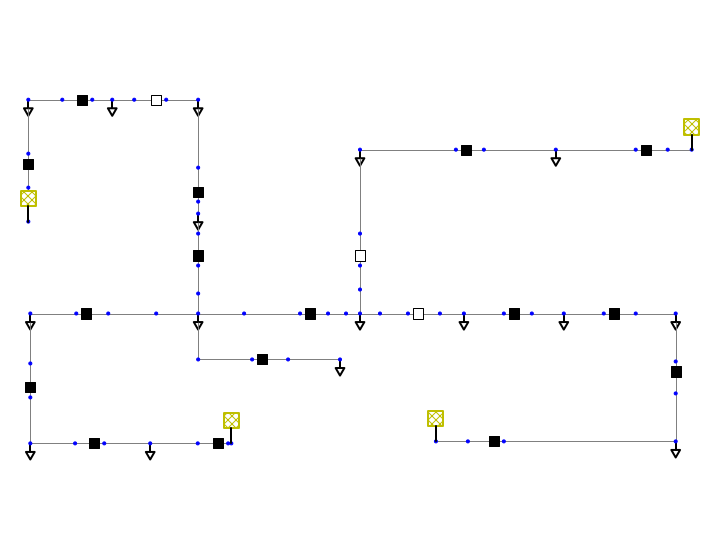

In [ ]:
#@title
from pandapower.plotting import simple_plot

#Criando rede
net = pp.create_empty_network()

#barras
pp.create_bus(net, 13.8, name='SE-A-01',geodata=(628,125))
pp.create_bus(net, 13.8, name='s1a',geodata=(620,125))
pp.create_bus(net, 13.8, name='s1b',geodata=(544,125))
pp.create_bus(net, 13.8, name='',geodata=(425,125))
pp.create_bus(net, 13.8, name='s2a',geodata=(310,125))
pp.create_bus(net, 13.8, name='s2b',geodata=(237,125))
pp.create_bus(net, 13.8, name='',geodata=(125,125))
pp.create_bus(net, 13.8, name='s3a',geodata=(125,240))
pp.create_bus(net, 13.8, name='s3b',geodata=(125,325))
pp.create_bus(net, 13.8, name='',geodata=(125,450))
pp.create_bus(net, 13.8, name='s4a',geodata=(240,450))
pp.create_bus(net, 13.8, name='s4b',geodata=(320,450))
pp.create_bus(net, 13.8, name='ignora',geodata=(440,450))
pp.create_bus(net, 13.8, name='',geodata=(545,450)) #conexao
pp.create_bus(net, 13.8, name='ignora',geodata=(545,335))
pp.create_bus(net, 13.8, name='s16a',geodata=(680,335))
pp.create_bus(net, 13.8, name='s16b',geodata=(770,335))
pp.create_bus(net, 13.8, name='',geodata=(900,335))
pp.create_bus(net, 13.8, name='ignora',geodata=(545,500))
pp.create_bus(net, 13.8, name='s14a',geodata=(545,570))
pp.create_bus(net, 13.8, name='s14b',geodata=(545,650))
pp.create_bus(net, 13.8, name='',geodata=(545,700))
pp.create_bus(net, 13.8, name='s15a',geodata=(545,730))
pp.create_bus(net, 13.8, name='s15b',geodata=(545,815))
pp.create_bus(net, 13.8, name='',geodata=(545,985))
pp.create_bus(net, 13.8, name='s12a',geodata=(465,985))
pp.create_bus(net, 13.8, name='s12b',geodata=(385,985))
pp.create_bus(net, 13.8, name='',geodata=(330,985))
pp.create_bus(net, 13.8, name='s11a',geodata=(280,985))
pp.create_bus(net, 13.8, name='s11b',geodata=(205,985))
pp.create_bus(net, 13.8, name='',geodata=(120,985))
pp.create_bus(net, 13.8, name='s10a',geodata=(120,850))
pp.create_bus(net, 13.8, name='s10b',geodata=(120,765))
pp.create_bus(net, 13.8, name='SE-B-01',geodata=(120,680))
pp.create_bus(net, 13.8, name='ignora',geodata=(660,450))
pp.create_bus(net, 13.8, name='s13a',geodata=(800,450))
pp.create_bus(net, 13.8, name='s13b',geodata=(870,450))
pp.create_bus(net, 13.8, name='ignora',geodata=(915,450))
pp.create_bus(net, 13.8, name='',geodata=(950,450)) #conexao
pp.create_bus(net, 13.8, name='ignora',geodata=(1000,450))
pp.create_bus(net, 13.8, name='s5a',geodata=(1070,450))
pp.create_bus(net, 13.8, name='s5b',geodata=(1150,450))
pp.create_bus(net, 13.8, name='',geodata=(1210,450))
pp.create_bus(net, 13.8, name='s6a',geodata=(1310,450))
pp.create_bus(net, 13.8, name='s6b',geodata=(1380,450))
pp.create_bus(net, 13.8, name='',geodata=(1460,450))
pp.create_bus(net, 13.8, name='s7a',geodata=(1560,450))
pp.create_bus(net, 13.8, name='s7b',geodata=(1640,450))
pp.create_bus(net, 13.8, name='',geodata=(1740,450))
pp.create_bus(net, 13.8, name='s8a',geodata=(1740,330))
pp.create_bus(net, 13.8, name='s8b',geodata=(1740,250))
pp.create_bus(net, 13.8, name='',geodata=(1740,130))
pp.create_bus(net, 13.8, name='s9a',geodata=(1310,130))
pp.create_bus(net, 13.8, name='s9b',geodata=(1220,130))
pp.create_bus(net, 13.8, name='SE-A-02',geodata=(1140,130))
pp.create_bus(net, 13.8, name='ignora',geodata=(950,510))
pp.create_bus(net, 13.8, name='s17a',geodata=(950,570))
pp.create_bus(net, 13.8, name='s17b',geodata=(950,650))
pp.create_bus(net, 13.8, name='',geodata=(950,860))
pp.create_bus(net, 13.8, name='s18a',geodata=(1190,860))
pp.create_bus(net, 13.8, name='s18b',geodata=(1260,860))
pp.create_bus(net, 13.8, name='',geodata=(1440,860))
pp.create_bus(net, 13.8, name='s19a',geodata=(1640,860))
pp.create_bus(net, 13.8, name='s19b',geodata=(1720,860))
pp.create_bus(net, 13.8, name='SE-C-01',geodata=(1780,860))
#Subestações
pp.create_ext_grid(net, bus=0, vm_pu=1.05, name="SE-A-01")
pp.create_ext_grid(net, bus=64, vm_pu=1.05, name="SE-A-02")
pp.create_ext_grid(net, bus=33, vm_pu=1.05, name="SE-B-01")
pp.create_ext_grid(net, bus=54, vm_pu=1.05, name="SE-C-01")
#Cargas
buses = net.bus.loc[net.bus['name']==''].index
pp.create_loads(net,buses,p_mw=0.04,q_mvar=0.004)
#linhas

pp.create_line(net, from_bus=30, to_bus=31, length_km= 1.0, std_type='15-AL1/3-ST1A 0.4', geodata=((120,985),(120,850)))
pp.create_line(net, from_bus=32, to_bus=33, length_km= 1.0, std_type='15-AL1/3-ST1A 0.4', geodata=((120,765),(120,680)))
pp.create_line(net, from_bus=6, to_bus=7, length_km= 1.0, std_type='15-AL1/3-ST1A 0.4', geodata=((125,125),(125,240)))
pp.create_line(net, from_bus=8, to_bus=9, length_km= 1.0, std_type='15-AL1/3-ST1A 0.4', geodata=((125,325),(125,450)))
pp.create_line(net, from_bus=9, to_bus=10, length_km= 1.0, std_type='15-AL1/3-ST1A 0.4', geodata=((125,450),(240,450)))
pp.create_line(net, from_bus=29, to_bus=30, length_km= 1.0, std_type='15-AL1/3-ST1A 0.4', geodata=((205,985),(120,985)))
pp.create_line(net, from_bus=5, to_bus=6, length_km= 1.0, std_type='15-AL1/3-ST1A 0.4', geodata=((237,125),(125,125)))
pp.create_line(net, from_bus=11, to_bus=12, length_km= 1.0, std_type='15-AL1/3-ST1A 0.4', geodata=((320,450),(440,450)))
pp.create_line(net, from_bus=27, to_bus=28, length_km= 1.0, std_type='15-AL1/3-ST1A 0.4', geodata=((330,985),(280,985)))
pp.create_line(net, from_bus=26, to_bus=27, length_km= 1.0, std_type='15-AL1/3-ST1A 0.4', geodata=((385,985),(330,985)))
pp.create_line(net, from_bus=3, to_bus=4, length_km= 1.0, std_type='15-AL1/3-ST1A 0.4', geodata=((425,125),(310,125)))
pp.create_line(net, from_bus=12, to_bus=13, length_km= 1.0, std_type='15-AL1/3-ST1A 0.4', geodata=((440,450),(545,450)))
pp.create_line(net, from_bus=2, to_bus=3, length_km= 1.0, std_type='15-AL1/3-ST1A 0.4', geodata=((544,125),(425,125)))
pp.create_line(net, from_bus=13, to_bus=14, length_km= 1.0, std_type='15-AL1/3-ST1A 0.4', geodata=((545,450),(545,335)))
pp.create_line(net, from_bus=13, to_bus=34, length_km= 1.0, std_type='15-AL1/3-ST1A 0.4', geodata=((545,450),(660,450)))
pp.create_line(net, from_bus=14, to_bus=15, length_km= 1.0, std_type='15-AL1/3-ST1A 0.4', geodata=((545,335),(680,335)))
pp.create_line(net, from_bus=13, to_bus=18, length_km= 1.0, std_type='15-AL1/3-ST1A 0.4', geodata=((545,450),(545,500)))
pp.create_line(net, from_bus=18, to_bus=19, length_km= 1.0, std_type='15-AL1/3-ST1A 0.4', geodata=((545,500),(545,570)))
pp.create_line(net, from_bus=20, to_bus=21, length_km= 1.0, std_type='15-AL1/3-ST1A 0.4', geodata=((545,650),(545,700)))
pp.create_line(net, from_bus=21, to_bus=22, length_km= 1.0, std_type='15-AL1/3-ST1A 0.4', geodata=((545,700),(545,730)))
pp.create_line(net, from_bus=23, to_bus=24, length_km= 1.0, std_type='15-AL1/3-ST1A 0.4', geodata=((545,815),(545,985)))
pp.create_line(net, from_bus=24, to_bus=25, length_km= 1.0, std_type='15-AL1/3-ST1A 0.4', geodata=((545,985),(465,985)))
pp.create_line(net, from_bus=0, to_bus=1, length_km= 1.0, std_type='15-AL1/3-ST1A 0.4', geodata=((628,125),(620,125)))
pp.create_line(net, from_bus=34, to_bus=35, length_km= 1.0, std_type='15-AL1/3-ST1A 0.4', geodata=((660,450),(800,450)))
pp.create_line(net, from_bus=16, to_bus=17, length_km= 1.0, std_type='15-AL1/3-ST1A 0.4', geodata=((770,335),(900,335)))
pp.create_line(net, from_bus=36, to_bus=37, length_km= 1.0, std_type='15-AL1/3-ST1A 0.4', geodata=((870,450),(915,450)))
pp.create_line(net, from_bus=37, to_bus=38, length_km= 1.0, std_type='15-AL1/3-ST1A 0.4', geodata=((915,450),(950,450)))
pp.create_line(net, from_bus=38, to_bus=39, length_km= 1.0, std_type='15-AL1/3-ST1A 0.4', geodata=((950,450),(1000,450)))
pp.create_line(net, from_bus=38, to_bus=55, length_km= 1.0, std_type='15-AL1/3-ST1A 0.4', geodata=((950,450),(950,510)))
pp.create_line(net, from_bus=55, to_bus=56, length_km= 1.0, std_type='15-AL1/3-ST1A 0.4', geodata=((950,510),(950,570)))
pp.create_line(net, from_bus=57, to_bus=58, length_km= 1.0, std_type='15-AL1/3-ST1A 0.4', geodata=((950,650),(950,860)))
pp.create_line(net, from_bus=58, to_bus=59, length_km= 1.0, std_type='15-AL1/3-ST1A 0.4', geodata=((950,860),(1190,860)))
pp.create_line(net, from_bus=39, to_bus=40, length_km= 1.0, std_type='15-AL1/3-ST1A 0.4', geodata=((1000,450),(1070,450)))
pp.create_line(net, from_bus=41, to_bus=42, length_km= 1.0, std_type='15-AL1/3-ST1A 0.4', geodata=((1150,450),(1210,450)))
pp.create_line(net, from_bus=42, to_bus=43, length_km= 1.0, std_type='15-AL1/3-ST1A 0.4', geodata=((1210,450),(1310,450)))
pp.create_line(net, from_bus=53, to_bus=54, length_km= 1.0, std_type='15-AL1/3-ST1A 0.4', geodata=((1220,130),(1140,130)))
pp.create_line(net, from_bus=60, to_bus=61, length_km= 1.0, std_type='15-AL1/3-ST1A 0.4', geodata=((1260,860),(1440,860)))
pp.create_line(net, from_bus=44, to_bus=45, length_km= 1.0, std_type='15-AL1/3-ST1A 0.4', geodata=((1380,450),(1460,450)))
pp.create_line(net, from_bus=61, to_bus=62, length_km= 1.0, std_type='15-AL1/3-ST1A 0.4', geodata=((1440,860),(1640,860)))
pp.create_line(net, from_bus=45, to_bus=46, length_km= 1.0, std_type='15-AL1/3-ST1A 0.4', geodata=((1460,450),(1560,450)))
pp.create_line(net, from_bus=47, to_bus=48, length_km= 1.0, std_type='15-AL1/3-ST1A 0.4', geodata=((1640,450),(1740,450)))
pp.create_line(net, from_bus=63, to_bus=64, length_km= 1.0, std_type='15-AL1/3-ST1A 0.4', geodata=((1720,860),(1780,860)))
pp.create_line(net, from_bus=48, to_bus=49, length_km= 1.0, std_type='15-AL1/3-ST1A 0.4', geodata=((1740,450),(1740,330)))
pp.create_line(net, from_bus=50, to_bus=51, length_km= 1.0, std_type='15-AL1/3-ST1A 0.4', geodata=((1740,250),(1740,130)))
pp.create_line(net, from_bus=51, to_bus=52, length_km= 1.0, std_type='15-AL1/3-ST1A 0.4', geodata=((1740,130),(1310,130)))
# linhas das chaves
pp.create_line(net, from_bus=1, to_bus=2, index=45, length_km= 0.01, std_type='15-AL1/3-ST1A 0.4', geodata=((620,125),(544,125)))
pp.create_line(net, from_bus=4, to_bus=5, index=46, length_km= 0.01, std_type='15-AL1/3-ST1A 0.4', geodata=((310,125),(237,125)))
pp.create_line(net, from_bus=7, to_bus=8, index=47, length_km= 0.01, std_type='15-AL1/3-ST1A 0.4', geodata=((125,240),(125,325)))
pp.create_line(net, from_bus=10, to_bus=11, index=48, length_km= 0.01, std_type='15-AL1/3-ST1A 0.4', geodata=((240,450),(320,450)))
pp.create_line(net, from_bus=15, to_bus=16, index=49, length_km= 0.01, std_type='15-AL1/3-ST1A 0.4', geodata=((680,335),(770,335)))
pp.create_line(net, from_bus=19, to_bus=20, index=50, length_km= 0.01, std_type='15-AL1/3-ST1A 0.4', geodata=((545,570),(545,650)))
pp.create_line(net, from_bus=22, to_bus=23, index=51, length_km= 0.01, std_type='15-AL1/3-ST1A 0.4', geodata=((545,730),(545,815)))
pp.create_line(net, from_bus=25, to_bus=26, index=52, length_km= 0.01, std_type='15-AL1/3-ST1A 0.4', geodata=((465,985),(385,985)))
pp.create_line(net, from_bus=28, to_bus=29, index=53, length_km= 0.01, std_type='15-AL1/3-ST1A 0.4', geodata=((280,985),(205,985)))
pp.create_line(net, from_bus=31, to_bus=32, index=54, length_km= 0.01, std_type='15-AL1/3-ST1A 0.4', geodata=((120,850),(120,765)))
pp.create_line(net, from_bus=35, to_bus=36, index=55, length_km= 0.01, std_type='15-AL1/3-ST1A 0.4', geodata=((800,450),(870,450)))
pp.create_line(net, from_bus=40, to_bus=41, index=56, length_km= 0.01, std_type='15-AL1/3-ST1A 0.4', geodata=((1070,450),(1150,450)))
pp.create_line(net, from_bus=43, to_bus=44, index=57, length_km= 0.01, std_type='15-AL1/3-ST1A 0.4', geodata=((1310,450),(1380,450)))
pp.create_line(net, from_bus=46, to_bus=47, index=58, length_km= 0.01, std_type='15-AL1/3-ST1A 0.4', geodata=((1560,450),(1640,450)))
pp.create_line(net, from_bus=49, to_bus=50, index=59, length_km= 0.01, std_type='15-AL1/3-ST1A 0.4', geodata=((1740,330),(1740,250)))
pp.create_line(net, from_bus=52, to_bus=53, index=60, length_km= 0.01, std_type='15-AL1/3-ST1A 0.4', geodata=((1310,130),(1220,130)))
pp.create_line(net, from_bus=56, to_bus=57, index=61, length_km= 0.01, std_type='15-AL1/3-ST1A 0.4', geodata=((950,570),(950,650)))
pp.create_line(net, from_bus=59, to_bus=60, index=62, length_km= 0.01, std_type='15-AL1/3-ST1A 0.4', geodata=((1190,860),(1260,860)))
pp.create_line(net, from_bus=62, to_bus=63, index=63, length_km= 0.01, std_type='15-AL1/3-ST1A 0.4', geodata=((1640,860),(1720,860)))

# criando uma chave por linha
pp.create_switch(net,bus=1, element=45,et='l', closed=True, type='CB', name='S1')
pp.create_switch(net,bus=4, element=46,et='l', closed=True, type='LBS', name='S2')
pp.create_switch(net,bus=7, element=47,et='l', closed=True, type='LBS', name='S3')
pp.create_switch(net,bus=10, element=48,et='l', closed=True, type='LBS', name='S4')
pp.create_switch(net,bus=40, element=56,et='l', closed=False, type='LBS', name='S5')
pp.create_switch(net,bus=43, element=57,et='l', closed=True, type='LBS', name='S6')
pp.create_switch(net,bus=46, element=58,et='l', closed=True, type='LBS', name='S7')
pp.create_switch(net,bus=49, element=59,et='l', closed=True, type='LBS', name='S8')
pp.create_switch(net,bus=52, element=60,et='l', closed=True, type='CB', name='S9')
pp.create_switch(net,bus=31, element=54,et='l', closed=True, type='CB', name='S10')
pp.create_switch(net,bus=28, element=53,et='l', closed=True, type='LBS', name='S11')
pp.create_switch(net,bus=25, element=52,et='l', closed=False, type='LBS', name='S12')
pp.create_switch(net,bus=35, element=55,et='l', closed=True, type='LBS', name='S13')
pp.create_switch(net,bus=19, element=50,et='l', closed=True, type='LBS', name='S14')
pp.create_switch(net,bus=22, element=51,et='l', closed=True, type='LBS', name='S15')
pp.create_switch(net,bus=15, element=49,et='l', closed=True, type='LBS', name='S16')
pp.create_switch(net,bus=56, element=61,et='l', closed=False, type='LBS', name='S17')
pp.create_switch(net,bus=59, element=62,et='l', closed=True, type='LBS', name='S18')
pp.create_switch(net,bus=62, element=63,et='l', closed=True, type='CB', name='S19')

simple_plot(net,bus_size=0.3, plot_loads=True, plot_line_switches=True)

# Basic Use

In [ ]:
# create multiagent selfhealing
mas = MASHSG(net=net, debugView='Full')
# init simulation
mas.begin()
# set fault bus
mas.setFaultBus(faultBus = 9)
# simulation step

while mas.step():
  print('Step', mas.t)

Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Step 11
Step 12
Step 13
Step 14
Step 15
Step 16
Step 17


## Simulation Results

In [ ]:
mas

,name,type,closed,vpu_from,vpu_to,ika
0,S1,CB,True,1.046914,1.046883,0.013001
1,S2,LBS,True,1.041094,1.041067,0.011394
2,S3,LBS,True,1.036044,1.036020,0.009780
3,S4,LBS,True,1.031768,1.031749,0.008158
4,S5,LBS,False,1.026343,1.042316,0.000000
5,S6,LBS,True,1.042699,1.042702,0.001609
6,S7,LBS,True,1.043850,1.043858,0.003216
7,S8,LBS,True,1.045770,1.045782,0.004822
8,S9,CB,True,1.048457,1.048472,0.006423
9,S10,CB,True,1.049232,1.049239,0.003200


In [ ]:
with open(f'report_09.html','w+') as f:
        html = '<!DOCTYPE html>\r\n'
        html += '<html>\r\n'
        html += '<head>\r\n'
        html += '   <link rel=\"stylesheet\" href=\"https://codepen.io/chriddyp/pen/bWLwgP.css\">\r\n'
        html += '</head>\r\n'
        html += '<body>\r\n'
        html += mas.to_html()
        html += '</body>\r\n'
        html += '</html>'
        f.write(html)